In [1]:
import base64
import collections
import copy
import cProfile
import datetime
import gc
import itertools
import json
import math
import os
import operator
import pickle
import random
import re
import shutil
import sys
import time

import bokeh
import cv2
import hyperopt
import Image
import keras
from keras import *
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import prophet
import pyflux
import pylab
import scipy
from scipy import signal
import seaborn as sns
import skimage
import sklearn
from sklearn import *
import statsmodels as sm
import tensorflow as tf
import tqdm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
mpl.rcParams['figure.figsize'] = 20, 12
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

linewidth = 1.0
dotsize = 15

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/lo

# Define Parameters

In [2]:
SPLIT_TEST_SIZE = 0.2

AUG_ROT_RNG = 0.05
AUG_W_SHIFT_RNG = .05
AUG_H_SHIFT_RNG = .05
AUG_SHEAR_RNG = .0
AUG_ZOOM_RNG = .05
AUG_CH_SHIFT_RNG = .0
AUG_FILL_MODE = 'wrap'
AUG_CVAL = 0.
AUG_H_FLIP = False
AUG_V_FLIP = False
AUG_SIZE_MULTIPLIER = 1

# Load the Data and Split Train/Validation

In [3]:
train_all_raw = pd.read_json('/media/ntfs/data/iceberg_classification/input/train.json')
train_all_size = len(train_all_raw)
print train_all_size

1604


In [4]:
train_all_x = np.zeros((train_all_size, 75, 75, 3))
train_all_y = np.zeros(train_all_size)

for i in range(train_all_size):
    for channel in range(2):
        train_all_x[i, :, :, channel] = (np.asarray(train_all_raw.iloc[i, channel]).reshape(75, 75) + 50) / 50
    train_all_x[i, :, :, 2] = np.zeros((75, 75))
    train_all_y[i] = train_all_raw.iloc[i, 4]
    
del train_all_raw
gc.collect()

56

In [5]:
train_x, val_x, train_y, val_y = sklearn.model_selection.train_test_split(
                                    train_all_x,
                                    train_all_y,
                                    test_size=SPLIT_TEST_SIZE)

del train_all_x
del train_all_y
gc.collect()

train_size = len(train_x)
val_size = len(val_x)

print train_size
print val_size

1283
321


# Data Augmentation

In [6]:
generator = keras.preprocessing.image.ImageDataGenerator(
                rotation_range=AUG_ROT_RNG,
                width_shift_range=AUG_W_SHIFT_RNG,
                height_shift_range=AUG_H_SHIFT_RNG,
                shear_range=AUG_SHEAR_RNG,
                zoom_range=AUG_ZOOM_RNG,
                channel_shift_range=AUG_CH_SHIFT_RNG,
                fill_mode=AUG_FILL_MODE,
                cval=AUG_CVAL,
                horizontal_flip=AUG_H_FLIP,
                vertical_flip=AUG_V_FLIP)

flow = generator.flow(train_x, train_y, batch_size=1)

In [7]:
train_aug_size = int(train_size * (1 + AUG_SIZE_MULTIPLIER))

train_aug_x = np.zeros((train_aug_size, 75, 75, 2))
train_aug_y = np.zeros(train_aug_size)

train_aug_x[:train_size, :, :, :] = train_x[:, :, :, 0:2]
train_aug_y[:train_size] = train_y[:]
            
i = train_size
for f in flow:
    train_aug_x[i, :, :, 0:2] = f[0][0, :, :, 0:2]
    train_aug_y[i] = f[1]
    
    i += 1
    if i >= train_aug_size:
        break

# Create Model

In [8]:
n_filters = 32
kernel_size = (3, 3)
max_pooling_size = (2, 2)
dropout = 0.2
dense_neurons = 2048

model = models.Sequential()

model.add(layers.Conv2D(n_filters, kernel_size, activation='relu', input_shape=(75, 75, 2)))
model.add(layers.MaxPooling2D(max_pooling_size))
model.add(keras.layers.Dropout(dropout))

model.add(layers.Conv2D(n_filters, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(max_pooling_size))
model.add(keras.layers.Dropout(dropout))

model.add(layers.Conv2D(n_filters, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(max_pooling_size))
model.add(keras.layers.Dropout(dropout))

model.add(layers.Conv2D(n_filters, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(max_pooling_size))
model.add(keras.layers.Dropout(dropout))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(dense_neurons, activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

print model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        9248      
__________

# Train and Evaluate

avg val acc.: 0.8586
log loss: 0.3435


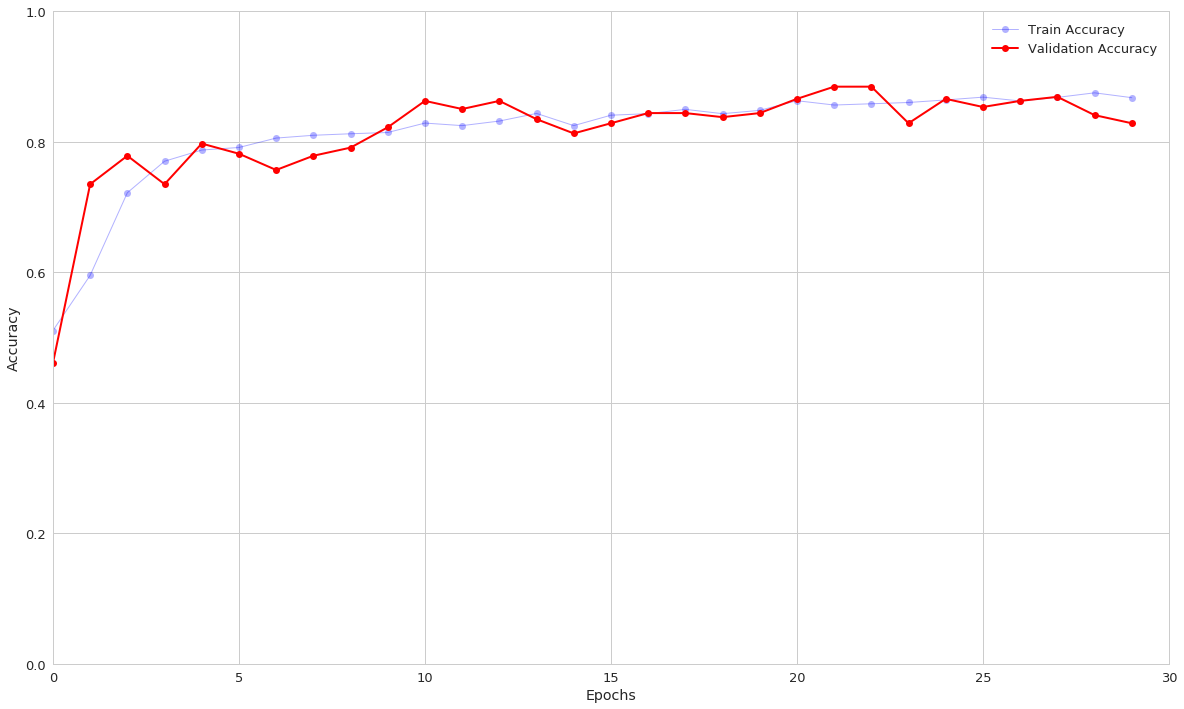

In [9]:
epochs = 30
batch_size = 16
t_x = train_aug_x
t_y = train_aug_y
v_x = val_x[:, :, :, 0:2]
v_y = val_y

history = model.fit(
            x=t_x,
            y=t_y,
            epochs=epochs,
            validation_data=(v_x, v_y),
            batch_size=batch_size,
            verbose=0)

acc = history.history['acc']
val_acc = history.history['val_acc']

print 'avg val acc.: {0:0.4f}'.format(np.average(val_acc[-10:]))

p = model.predict(v_x)
print 'log loss: {0:0.4f}'.format(sklearn.metrics.log_loss(v_y, p))

eps = range(len(acc))

_ = plt.plot(eps, acc, 'bo-', label='Train Accuracy', linewidth=linewidth, alpha=0.3)
_ = plt.plot(eps, val_acc, 'ro-', label='Validation Accuracy', linewidth=2*linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Accuracy')

_ = plt.xlim((0, epochs))
_ = plt.ylim((0, 1))

_ = plt.legend()